# Design and Refactoring

## Coupling

The <i>fit_trendline</i> function calls the <i>process_sdg_data</i> function internally to perform the data processing. If you change the behavior of the <i>process_sdg_function</i>, it could potentially affect the behavior of the <i>fit_trendline</i> function. Mixing these functions makes them harder to work with.

In [26]:
# Example of tightly coupled functions
import pandas as pd
from scipy.stats import linregress


def process_sdg_data(input_excel_file, columns_to_drop):
    # full_path_to_file = "data/" + input_excel_file  # include the 'data' subdirectory
    df = pd.read_excel(input_excel_file)
    df = df.drop(columns_to_drop, axis=1)
    df = df.set_index("GeoAreaName").transpose()
    return df


def fit_trendline(country_name):
    df = process_sdg_data(
        "../data/SG_GEN_PARL.xlsx",
        [
            "Goal",
            "Target",
            "Indicator",
            "SeriesCode",
            "SeriesDescription",
            "GeoAreaCode",
            "Reporting Type",
            "Sex",
            "Units",
        ],
    )
    timestamps = [int(i) for i in df.index.tolist()]
    data = df[country_name].tolist()

    result = linregress(timestamps, data)
    slope = round(result.slope, 3)
    r_squared = round(result.rvalue**2, 3)
    return slope, r_squared

In [31]:
fit_trendline("United States of America")

(0.592, 0.841)

Separating the functions like this makes them much easier to work with, and it’s also much easier to reuse them elsewhere.

In [34]:
# Loosely coupled functions

import pandas as pd
from scipy.stats import linregress


def fit_trendline(year_timestamps, data):
    result = linregress(year_timestamps, data)
    slope = round(result.slope, 3)
    r_squared = round(result.rvalue**2, 3)
    return slope, r_squared


def process_sdg_data(input_excel_file, columns_to_drop):
    df = pd.read_excel(input_excel_file)
    df = df.drop(columns_to_drop, axis=1)
    df = df.set_index("GeoAreaName").transpose()
    return df


df = process_sdg_data(
    "../data/SG_GEN_PARL.xlsx",
    [
        "Goal",
        "Target",
        "Indicator",
        "SeriesCode",
        "SeriesDescription",
        "GeoAreaCode",
        "Reporting Type",
        "Sex",
        "Units",
    ],
)
timestamps = [int(i) for i in df.index.tolist()]
country_data = df["United States of America"].tolist()
slope, r_squared = fit_trendline(timestamps, country_data)

In [35]:
slope

0.592

## Creating Scripts From Notebooks

In [ ]:
import pandas as pd

In [36]:
def process_sdg_data(input_excel_file, columns_to_drop, output_csv_file):
    df = pd.read_excel(input_excel_file)
    df = df.drop(columns_to_drop, axis=1)
    df = df.set_index("GeoAreaName").transpose()
    df.to_csv(output_csv_file, index="GeoAreaName")

In [37]:
import os


def test_process_sdg_data():

    test_filepath = "test_sgd_data.csv"

    process_sdg_data(
        "../data/SG_GEN_PARL.xlsx",
        [
            "Goal",
            "Target",
            "Indicator",
            "SeriesCode",
            "SeriesDescription",
            "GeoAreaCode",
            "Reporting Type",
            "Sex",
            "Units",
        ],
        test_filepath,
    )

    df = pd.read_csv(test_filepath)

    assert len(df) == 24
    assert len(df.columns) == 196

    # cleanup step - delete the file produced in the test
    os.remove(test_filepath)

In [38]:
test_process_sdg_data()

### Webscraping using pandas

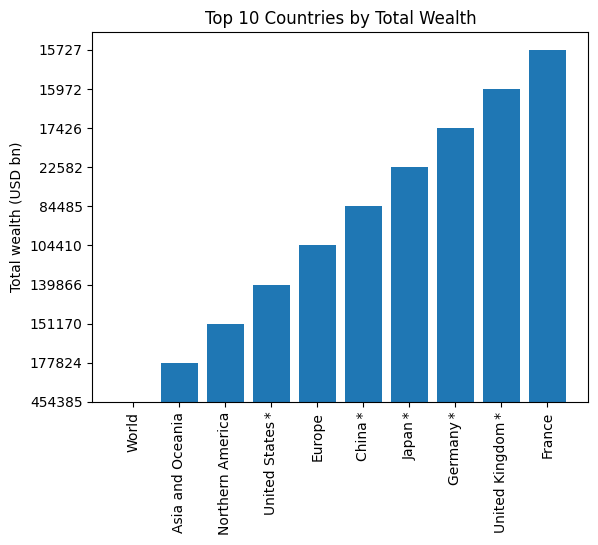

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Wikipedia page for total wealth data
url = 'https://en.wikipedia.org/wiki/List_of_countries_by_total_wealth'

# read HTML tables from URL
tables = pd.read_html(url)

# extract the first table (which contains the wealth data)
wealth_table = tables[0]

wealth_table["Total wealth (USD bn)"] = wealth_table['Total wealth (USD bn)'].replace("—",pd.NA)

# remove unnecessary columns

wealth_table = wealth_table[['Country (or area)', 'Total wealth (USD bn)']]

# remove rows with missing values
wealth_table = wealth_table.dropna()

top10 = wealth_table.head(10)

# plot a bar chart of the top 10 countries by total wealth
plt.bar(top10['Country (or area)'], top10['Total wealth (USD bn)'])
plt.xticks(rotation=90)
plt.ylabel('Total wealth (USD bn)')
plt.title('Top 10 Countries by Total Wealth')
plt.show()

### Factory Pattern

In [1]:
from __future__ import annotations
from abc import ABC, abstractmethod


class Creator(ABC):
    """
    The Creator class declares the factory method that is supposed to return an
    object of a Product class. The Creator's subclasses usually provide the
    implementation of this method.
    """

    @abstractmethod
    def factory_method(self):
        """
        Note that the Creator may also provide some default implementation of
        the factory method.
        """
        pass

    def some_operation(self) -> str:
        """
        Also note that, despite its name, the Creator's primary responsibility
        is not creating products. Usually, it contains some core business logic
        that relies on Product objects, returned by the factory method.
        Subclasses can indirectly change that business logic by overriding the
        factory method and returning a different type of product from it.
        """

        # Call the factory method to create a Product object.
        product = self.factory_method()

        # Now, use the product.
        result = f"Creator: The same creator's code has just worked with {product.operation()}"

        return result


"""
Concrete Creators override the factory method in order to change the resulting
product's type.
"""


class ConcreteCreator1(Creator):
    """
    Note that the signature of the method still uses the abstract product type,
    even though the concrete product is actually returned from the method. This
    way the Creator can stay independent of concrete product classes.
    """

    def factory_method(self) -> Product:
        return ConcreteProduct1()


class ConcreteCreator2(Creator):
    def factory_method(self) -> Product:
        return ConcreteProduct2()


class Product(ABC):
    """
    The Product interface declares the operations that all concrete products
    must implement.
    """

    @abstractmethod
    def operation(self) -> str:
        pass


"""
Concrete Products provide various implementations of the Product interface.
"""


class ConcreteProduct1(Product):
    def operation(self) -> str:
        return "{Result of the ConcreteProduct1}"


class ConcreteProduct2(Product):
    def operation(self) -> str:
        return "{Result of the ConcreteProduct2}"


def client_code(creator: Creator) -> None:
    """
    The client code works with an instance of a concrete creator, albeit through
    its base interface. As long as the client keeps working with the creator via
    the base interface, you can pass it any creator's subclass.
    """

    print(f"Client: I'm not aware of the creator's class, but it still works.\n"
          f"{creator.some_operation()}", end="")


if __name__ == "__main__":
    print("App: Launched with the ConcreteCreator1.")
    client_code(ConcreteCreator1())
    print("\n")

    print("App: Launched with the ConcreteCreator2.")
    client_code(ConcreteCreator2())

App: Launched with the ConcreteCreator1.
Client: I'm not aware of the creator's class, but it still works.
Creator: The same creator's code has just worked with {Result of the ConcreteProduct1}

App: Launched with the ConcreteCreator2.
Client: I'm not aware of the creator's class, but it still works.
Creator: The same creator's code has just worked with {Result of the ConcreteProduct2}

### Singleton Pattern

In [3]:
from threading import Lock, Thread


class SingletonMeta(type):
    """
    This is a thread-safe implementation of Singleton.
    """

    _instances = {}

    _lock: Lock = Lock()
    """
    We now have a lock object that will be used to synchronize threads during
    first access to the Singleton.
    """

    def __call__(cls, *args, **kwargs):
        """
        Possible changes to the value of the `__init__` argument do not affect
        the returned instance.
        """
        # Now, imagine that the program has just been launched. Since there's no
        # Singleton instance yet, multiple threads can simultaneously pass the
        # previous conditional and reach this point almost at the same time. The
        # first of them will acquire lock and will proceed further, while the
        # rest will wait here.
        with cls._lock:
            # The first thread to acquire the lock, reaches this conditional,
            # goes inside and creates the Singleton instance. Once it leaves the
            # lock block, a thread that might have been waiting for the lock
            # release may then enter this section. But since the Singleton field
            # is already initialized, the thread won't create a new object.
            if cls not in cls._instances:
                instance = super().__call__(*args, **kwargs)
                cls._instances[cls] = instance
        return cls._instances[cls]


class Singleton(metaclass=SingletonMeta):
    value: str = None
    """
    We'll use this property to prove that our Singleton really works.
    """

    def __init__(self, value: str) -> None:
        self.value = value

    def some_business_logic(self):
        """
        Finally, any singleton should define some business logic, which can be
        executed on its instance.
        """


def test_singleton(value: str) -> None:
    singleton = Singleton(value)
    print(singleton.value)


if __name__ == "__main__":
    # The client code.

    print("If you see the same value, then singleton was reused (yay!)\n"
          "If you see different values, "
          "then 2 singletons were created (booo!!)\n\n"
          "RESULT:\n")

    process1 = Thread(target=test_singleton, args=("FOO",))
    process2 = Thread(target=test_singleton, args=("BAR",))
    process1.start()
    process2.start()

If you see the same value, then singleton was reused (yay!)
If you see different values, then 2 singletons were created (booo!!)

RESULT:

FOO
FOO


### Adapter Pattern

In [4]:
class Target:
    """
    The Target defines the domain-specific interface used by the client code.
    """

    def request(self) -> str:
        return "Target: The default target's behavior."


class Adaptee:
    """
    The Adaptee contains some useful behavior, but its interface is incompatible
    with the existing client code. The Adaptee needs some adaptation before the
    client code can use it.
    """

    def specific_request(self) -> str:
        return ".eetpadA eht fo roivaheb laicepS"


class Adapter(Target):
    """
    The Adapter makes the Adaptee's interface compatible with the Target's
    interface via composition.
    """

    def __init__(self, adaptee: Adaptee) -> None:
        self.adaptee = adaptee

    def request(self) -> str:
        return f"Adapter: (TRANSLATED) {self.adaptee.specific_request()[::-1]}"


def client_code(target: Target) -> None:
    """
    The client code supports all classes that follow the Target interface.
    """

    print(target.request(), end="")


if __name__ == "__main__":
    print("Client: I can work just fine with the Target objects:")
    target = Target()
    client_code(target)
    print("\n")

    adaptee = Adaptee()
    print("Client: The Adaptee class has a weird interface. "
          "See, I don't understand it:")
    print(f"Adaptee: {adaptee.specific_request()}", end="\n\n")

    print("Client: But I can work with it via the Adapter:")
    adapter = Adapter(adaptee)
    client_code(adapter)

Client: I can work just fine with the Target objects:
Target: The default target's behavior.

Client: The Adaptee class has a weird interface. See, I don't understand it:
Adaptee: .eetpadA eht fo roivaheb laicepS

Client: But I can work with it via the Adapter:
Adapter: (TRANSLATED) Special behavior of the Adaptee.

### Observer Pattern

In [5]:
from __future__ import annotations
from abc import ABC, abstractmethod
from random import randrange
from typing import List


class Subject(ABC):
    """
    The Subject interface declares a set of methods for managing subscribers.
    """

    @abstractmethod
    def attach(self, observer: Observer) -> None:
        """
        Attach an observer to the subject.
        """
        pass

    @abstractmethod
    def detach(self, observer: Observer) -> None:
        """
        Detach an observer from the subject.
        """
        pass

    @abstractmethod
    def notify(self) -> None:
        """
        Notify all observers about an event.
        """
        pass


class ConcreteSubject(Subject):
    """
    The Subject owns some important state and notifies observers when the state
    changes.
    """

    _state: int = None
    """
    For the sake of simplicity, the Subject's state, essential to all
    subscribers, is stored in this variable.
    """

    _observers: List[Observer] = []
    """
    List of subscribers. In real life, the list of subscribers can be stored
    more comprehensively (categorized by event type, etc.).
    """

    def attach(self, observer: Observer) -> None:
        print("Subject: Attached an observer.")
        self._observers.append(observer)

    def detach(self, observer: Observer) -> None:
        self._observers.remove(observer)

    """
    The subscription management methods.
    """

    def notify(self) -> None:
        """
        Trigger an update in each subscriber.
        """

        print("Subject: Notifying observers...")
        for observer in self._observers:
            observer.update(self)

    def some_business_logic(self) -> None:
        """
        Usually, the subscription logic is only a fraction of what a Subject can
        really do. Subjects commonly hold some important business logic, that
        triggers a notification method whenever something important is about to
        happen (or after it).
        """

        print("\nSubject: I'm doing something important.")
        self._state = randrange(0, 10)

        print(f"Subject: My state has just changed to: {self._state}")
        self.notify()


class Observer(ABC):
    """
    The Observer interface declares the update method, used by subjects.
    """

    @abstractmethod
    def update(self, subject: Subject) -> None:
        """
        Receive update from subject.
        """
        pass


"""
Concrete Observers react to the updates issued by the Subject they had been
attached to.
"""


class ConcreteObserverA(Observer):
    def update(self, subject: Subject) -> None:
        if subject._state < 3:
            print("ConcreteObserverA: Reacted to the event")


class ConcreteObserverB(Observer):
    def update(self, subject: Subject) -> None:
        if subject._state == 0 or subject._state >= 2:
            print("ConcreteObserverB: Reacted to the event")


if __name__ == "__main__":
    # The client code.

    subject = ConcreteSubject()

    observer_a = ConcreteObserverA()
    subject.attach(observer_a)

    observer_b = ConcreteObserverB()
    subject.attach(observer_b)

    subject.some_business_logic()
    subject.some_business_logic()

    subject.detach(observer_a)

    subject.some_business_logic()

Subject: Attached an observer.
Subject: Attached an observer.

Subject: I'm doing something important.
Subject: My state has just changed to: 0
Subject: Notifying observers...
ConcreteObserverA: Reacted to the event
ConcreteObserverB: Reacted to the event

Subject: I'm doing something important.
Subject: My state has just changed to: 8
Subject: Notifying observers...
ConcreteObserverB: Reacted to the event

Subject: I'm doing something important.
Subject: My state has just changed to: 8
Subject: Notifying observers...
ConcreteObserverB: Reacted to the event


## Strategy Pattern

Here's an example of a data science problem that can be solved using the Strategy pattern:

Problem:

Imagine you're a data scientist working for a company that sells products online. You want to recommend products to customers based on their past purchases and browsing history. However, the company has multiple product categories, such as electronics, clothing, and home goods, each with its own unique characteristics and recommendation algorithms.

Goal:

Your goal is to develop a recommendation system that can handle different product categories and recommendation algorithms, while also being flexible and scalable.

Strategy Pattern Solution:

To solve this problem, you can use the Strategy pattern to define a family of algorithms for recommending products, each tailored to a specific product category. Here's an example:

In [3]:
# Define the Strategy interface
class RecommendationStrategy:
    def recommend(self, customer_id, products):
        pass

# Concrete Strategy classes for each product category
class ElectronicsRecommendationStrategy(RecommendationStrategy):
    def recommend(self, customer_id, products):
        # Implement recommendation algorithm for electronics
        return [product for product in products if product.category == "Electronics"]

class ClothingRecommendationStrategy(RecommendationStrategy):
    def recommend(self, customer_id, products):
        # Implement recommendation algorithm for clothing
        return [product for product in products if product.category == "Clothing"]

class HomeGoodsRecommendationStrategy(RecommendationStrategy):
    def recommend(self, customer_id, products):
        # Implement recommendation algorithm for home goods
        return [product for product in products if product.category == "Home Goods"]

# Context class that uses the Strategy pattern
class RecommendationSystem:
    def __init__(self, strategy):
        self.strategy = strategy

    def recommend(self, customer_id, products):
        return self.strategy.recommend(customer_id, products)

# Client code
products = [Product("Electronics"), Product("Clothing"), Product("Home Goods")]
customer_id = "12345";

# Create a RecommendationSystem instance with a specific strategy
electronics_strategy = ElectronicsRecommendationStrategy()
recommendation_system = RecommendationSystem(electronics_strategy)
recommended_products = recommendation_system.recommend(customer_id, products)
print(recommended_products)

# Switch to a different strategy
clothing_strategy = ClothingRecommendationStrategy()
recommendation_system = RecommendationSystem(clothing_strategy)
recommended_products = recommendation_system.recommend(customer_id, products)
print(recommended_products)

NameError: name 'Product' is not defined

### Strategy Pattern Conceptual Example

In [1]:
from __future__ import annotations
from abc import ABC, abstractmethod
from typing import List


class Context():
    """
    The Context defines the interface of interest to clients.
    """

    def __init__(self, strategy: Strategy) -> None:
        """
        Usually, the Context accepts a strategy through the constructor, but
        also provides a setter to change it at runtime.
        """

        self._strategy = strategy

    @property
    def strategy(self) -> Strategy:
        """
        The Context maintains a reference to one of the Strategy objects. The
        Context does not know the concrete class of a strategy. It should work
        with all strategies via the Strategy interface.
        """

        return self._strategy

    @strategy.setter
    def strategy(self, strategy: Strategy) -> None:
        """
        Usually, the Context allows replacing a Strategy object at runtime.
        """

        self._strategy = strategy

    def do_some_business_logic(self) -> None:
        """
        The Context delegates some work to the Strategy object instead of
        implementing multiple versions of the algorithm on its own.
        """

        # ...

        print("Context: Sorting data using the strategy (not sure how it'll do it)")
        result = self._strategy.do_algorithm(["a", "b", "c", "d", "e"])
        print(",".join(result))

        # ...


class Strategy(ABC):
    """
    The Strategy interface declares operations common to all supported versions
    of some algorithm.

    The Context uses this interface to call the algorithm defined by Concrete
    Strategies.
    """

    @abstractmethod
    def do_algorithm(self, data: List):
        pass


"""
Concrete Strategies implement the algorithm while following the base Strategy
interface. The interface makes them interchangeable in the Context.
"""


class ConcreteStrategyA(Strategy):
    def do_algorithm(self, data: List) -> List:
        return sorted(data)


class ConcreteStrategyB(Strategy):
    def do_algorithm(self, data: List) -> List:
        return reversed(sorted(data))


if __name__ == "__main__":
    # The client code picks a concrete strategy and passes it to the context.
    # The client should be aware of the differences between strategies in order
    # to make the right choice.

    context = Context(ConcreteStrategyA())
    print("Client: Strategy is set to normal sorting.")
    context.do_some_business_logic()
    print()

    print("Client: Strategy is set to reverse sorting.")
    context.strategy = ConcreteStrategyB()
    context.do_some_business_logic()

Client: Strategy is set to normal sorting.
Context: Sorting data using the strategy (not sure how it'll do it)
a,b,c,d,e

Client: Strategy is set to reverse sorting.
Context: Sorting data using the strategy (not sure how it'll do it)
e,d,c,b,a
